In [1]:
# Nonlinear MPC test using kinematic bicycle model for car
# We want to use the kinematic bicycle model from this paper (Figure 3)
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4

# which has states:
# x, y = positional coordinates in inertial frame
# ψ = angle of car centerline in inertial frame
# ̇ψ = change of angle
# β = angle between car centerline and velocity vector
# ̇β = change of angle

# and has the equations:
# ̇x = v cos(ψ + β)
# ̇y = v sin(ψ + β)
# ̇v = a
# ̇ψ = v / lᵣ sin(β)
# β = arctan(lᵣ/(lf + lᵣ) tan(δf))
# ̇β = v/(lf + lᵣ) tan(δf) - v/lᵣ sin(β)
# ̇δf = ω

# and we want to solve it. Define the model:


The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\\ \beta\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}
where the two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).
The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
\\
\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}
\end{gather*}

## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [2]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar
from roadrunner          import Roadrunner, RoadSegment
from road                import test_road, iso_double_lane_change

## Initial state and cost

In [3]:
# Initialize the car model with 0.05 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.05)
        
# Initial conditions: x,y = 0,0, velocity = 5.5 m/s, car at 22.5-degree angle
# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
ic = [0.0, 0.0, 5.5, np.pi/8, 0.0]
car.set_initial(ic)

# Cost - we want the velocity to stay around 5 m/s, so we penalize deviations from that.
cost = (car.dae.x[0][2]-5)**2

In [19]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(test_road, np.ones(n_test_road_pts)*3.0, P = 20)

# Boundary functions
global prev_k
prev_k= 0
dist_already_traveled = 0.0

def road_center(model:KinematicBicycleCar, k:int):
    global prev_k
    if k == prev_k+1:
        roadrunner.advance(model.step*model.state_estimate[2,k])
        prev_k = k
    if k == 0:
        roadrunner.reset()
        roadrunner.advance(dist_already_traveled)
        prev_k = k
    xy = np.reshape(roadrunner.evaluate(),2)

    return xy

def upperbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.upperbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 2*np.cos(angle))
    bound[0] = xy[0] + xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 2*np.sin(angle))
    bound[1] = xy[1] + xy_1*np.sign(xy_1)
    
    return bound

def lowerbounds_x(model:KinematicBicycleCar, k:int):
    xy = road_center(model, k)
    bound = model.lowerbounds_x(k)
    
    # Add the road width
    angle = roadrunner.get_angle()
    width = roadrunner.get_width()
    
    xy_0 = (width/2*np.cos(np.pi/2 + angle) + 2*np.cos(angle))
    bound[0] = xy[0] - xy_0*np.sign(xy_0)
    xy_1 = (width/2*np.sin(np.pi/2 + angle) + 2*np.sin(angle))
    bound[1] = xy[1] - xy_1*np.sign(xy_1)
    
    return bound

def upperbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.upperbounds_u(k)
    return bound

def lowerbounds_u(model:KinematicBicycleCar, k:int):
    bound = model.lowerbounds_u(k)
    return bound


In [20]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints
# 3. Use the midpoints to initialize the variable estimate so the solver is faster.
from collections import deque

v_estimate = np.ones(car.N)*ic[2]
road_points = deque(maxlen=car.N)
dist = 0.0
roadrunner.reset()

for v in v_estimate:
    roadrunner.advance(v*car.step)
    xy = roadrunner.evaluate()
    road_points.append(np.reshape(xy,2))

# Plot test
#test = np.empty((car.N,2))
#for i, pt in enumerate(road_points):
#    test[i,:] = pt
#plt.plot(test[:,0], test[:,1])
#plt.scatter(test_road[0:3,0], test_road[0:3,1])

## Run the MPC algorithm

In [ ]:
roadrunner.reset()
prev_k = 0

mpcprob = MpcProblem(car,     # casadi.DaeBuilder()
                     cost,        # casadi symbolic objective
                     upperbounds_x=upperbounds_x,
                     lowerbounds_x=lowerbounds_x,
                     upperbounds_u=upperbounds_u,
                     lowerbounds_u=lowerbounds_u,
                     road_center=road_center,
                    )

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs = 20

x_plan = np.empty((mpcprob.model.n,n_runs+1))
u_plan = np.empty((mpcprob.model.m,n_runs))
x_true = np.empty((mpcprob.model.n,n_runs+1))
x_true[:,0] = ic
x_plan[:,0] = ic

boundary_up  = np.empty((n_runs,2))
boundary_low = np.empty((n_runs,2))


for k in range(n_runs):
    xk_opt, uk_opt = mpcprob.run(x_true[:,k])
    for i in range(5):
        x_plan[i,k+1] = xk_opt[i][1]
    for i in range(2):
        u_plan[i,k] = uk_opt[i][1]
    x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])
    
    dist_already_traveled += np.sqrt((x_true[0,k+1]-x_true[0,k])**2 + (x_true[1,k+1]-x_true[1,k])**2)

    boundary_up[k,:] = upperbounds_x(mpcprob.model, 0)[0:2]
    boundary_low[k,:] = lowerbounds_x(mpcprob.model, 0)[0:2]
        
    
    # hack to demonstrate changing the cost halfway through the number of runs
    #if k = n_runs//2:
        # now the cost is penalizing velocity, so the car will stop.
    #    mpcprob.set_cost(100*car.dae.x[0][2]**2)

# This was to compare the error between the prediction and
# the simulation using casadi ODE integrator
# the error is very small.
#for k in range(1,n_runs):
    #print("True:", x_true[:,k])
    #print("Pred:", x_plan[:,k])
    #print("Error:", np.linalg.norm(x_true[:,k]-x_plan[:,k],2))

# Get the planned boundaries
boundary_plan_up = np.empty((mpcprob.model.N,2))
boundary_plan_low = np.empty((mpcprob.model.N,2))
for k in range(mpcprob.model.N):
    boundary_plan_up[k,:] = upperbounds_x(mpcprob.model, k)[0:2]
    boundary_plan_low[k,:] = lowerbounds_x(mpcprob.model, k)[0:2]
    
# Add them to the boundaries for past states
boundary_up = np.concatenate([boundary_up, boundary_plan_up])
boundary_low = np.concatenate([boundary_low, boundary_plan_low])

0 xy_k [0.50481786 0.79639044]
1 xy_k [0.51638945 0.79716511]
2 xy_k [0.5237317  0.79765731]
3 xy_k [0.52929297 0.79803046]
4 xy_k [0.53406172 0.79835067]
5 xy_k [0.53846321 0.7986464 ]
6 xy_k [0.54268552 0.79893028]
7 xy_k [0.54681909 0.79920835]
8 xy_k [0.55091238 0.79948386]
9 xy_k [0.5549947 0.7997588]
10 xy_k [0.55908627 0.80003452]
11 xy_k [0.56320288 0.80031208]
12 xy_k [0.5673581  0.80059241]
13 xy_k [0.57156447 0.80087636]
14 xy_k [0.57583408 0.80116474]
15 xy_k [0.58017887 0.80145838]
16 xy_k [0.58461082 0.80175809]
17 xy_k [0.58914205 0.8020647 ]
18 xy_k [0.59378486 0.80237907]
19 xy_k [0.59855171 0.80270203]
20 xy_k [0.60345509 0.80303447]
21 xy_k [0.60850735 0.80337724]
22 xy_k [0.6137202  0.80373115]
23 xy_k [0.619104   0.80409693]
24 xy_k [0.62466644 0.80447513]
25 xy_k [0.63041049 0.80486597]
26 xy_k [0.63633079 0.80526912]
27 xy_k [0.64240733 0.80568325]
28 xy_k [0.64859324 0.80610518]
29 xy_k [0.65478712 0.806528  ]
This is Ipopt version 3.12.3, running with linear so

0 xy_k [1.13024435 0.83997245]
1 xy_k [1.32885198 0.85447346]
2 xy_k [1.51720209 0.86848275]
3 xy_k [1.69524812 0.88193775]
4 xy_k [1.86295258 0.89478488]
5 xy_k [2.02790886 0.90757261]
6 xy_k [2.19123082 0.92036908]
7 xy_k [2.3531087  0.93317376]
8 xy_k [2.51361141 0.9459779 ]
9 xy_k [2.67303151 0.95879185]
10 xy_k [2.83198568 0.97165365]
11 xy_k [2.99068245 0.98456983]
12 xy_k [3.14945785 0.99755809]
13 xy_k [3.42789348 0.99134188]
14 xy_k [3.58712925 1.0019958 ]
15 xy_k [3.74711789 1.01270704]
16 xy_k [3.90818117 1.02348266]
17 xy_k [4.07061935 1.0343289 ]
18 xy_k [4.23469651 1.04524985]
19 xy_k [4.40066063 1.05624873]
20 xy_k [4.56854146 1.06731435]
21 xy_k [4.73832128 1.07843267]
22 xy_k [4.91007181 1.08959572]
23 xy_k [5.08375947 1.10078889]
24 xy_k [5.25929144 1.11199414]
25 xy_k [5.43652807 1.12319097]
26 xy_k [5.61518683 1.13435068]
27 xy_k [5.79521186 1.14545961]
28 xy_k [5.97538812 1.15643446]
29 xy_k [6.22932936 1.1855161 ]
This is Ipopt version 3.12.3, running with linear 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.2437288e-01 4.19e-04 3.51e-05  -5.7 2.37e-01  -3.9 1.00e+00 9.25e-01H  1
  31  2.2436790e-01 4.69e-03 9.88e-05  -5.7 7.08e-01  -4.4 9.57e-01 4.70e-01F  1
  32  2.2436509e-01 4.67e-03 4.38e-05  -5.7 3.26e+01    -  4.06e-02 4.06e-03h  2
  33  2.2436069e-01 3.62e-03 1.05e-05  -5.7 4.45e-01    -  1.00e+00 1.00e+00h  1
  34  2.2435821e-01 3.49e-03 2.44e-04  -5.7 2.86e+00  -4.9 3.34e-01 3.38e-02h  2
  35  2.2435308e-01 2.40e-05 1.13e-05  -5.7 3.99e-02  -3.6 1.00e+00 1.00e+00h  1
  36  2.2434619e-01 1.75e-05 2.71e-06  -5.7 7.90e-02    -  1.00e+00 9.83e-01H  1
  37  2.2430380e-01 3.16e-03 1.18e-06  -8.6 2.86e-01    -  8.23e-01 8.25e-01h  1
  38  2.2429591e-01 5.54e-04 2.50e-06  -8.6 1.71e-02    -  9.97e-01 8.31e-01h  1
  39  2.2429427e-01 6.81e-08 4.30e-10  -8.6 1.52e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.2429427e-01 1.61e-13

  54  1.7645990e-01 3.62e-05 1.71e-08  -8.6 1.88e-02    -  1.00e+00 1.00e+00f  1
  55  1.7645979e-01 3.62e-05 3.01e-09  -8.6 1.93e-02    -  1.00e+00 9.74e-01h  1
  56  1.7645979e-01 2.37e-08 5.18e-12  -8.6 4.76e-04    -  1.00e+00 1.00e+00f  1
  57  1.7645975e-01 9.62e-09 3.55e-12  -9.0 3.03e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:   1.7645974798307412e-01    1.7645974798307412e-01
Dual infeasibility......:   3.5506981220707450e-12    3.5506981220707450e-12
Constraint violation....:   9.6207767308342795e-09    9.6207767308342795e-09
Complementarity.........:   9.1114477780361018e-10    9.1114477780361018e-10
Overall NLP error.......:   9.6207767308342795e-09    9.6207767308342795e-09


Number of objective function evaluations             = 71
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 71
Number of ine

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.5046646e-01 1.81e-04 2.88e-05  -5.7 6.72e-02  -3.4 1.00e+00 1.00e+00h  1
  61  1.5045450e-01 2.84e-03 3.57e-05  -5.7 2.15e-01  -3.8 1.00e+00 1.00e+00h  1
  62  1.5044526e-01 7.78e-04 3.41e-05  -5.7 9.21e-02  -3.4 1.00e+00 1.00e+00h  1
  63  1.5042987e-01 3.37e-04 3.10e-05  -5.7 2.53e-01  -3.9 1.00e+00 9.17e-01H  1
  64  1.5042695e-01 2.16e-04 2.27e-05  -5.7 6.62e-02  -3.5 1.00e+00 1.00e+00f  1
  65  1.5042246e-01 2.01e-04 1.02e-05  -5.7 8.96e-02  -3.9 1.00e+00 1.00e+00h  1
  66  1.5042093e-01 3.65e-05 1.01e-05  -5.7 3.36e-02  -3.5 1.00e+00 1.00e+00h  1
  67  1.5041882e-01 3.85e-04 1.02e-05  -5.7 9.90e-02  -4.0 1.00e+00 1.00e+00h  1
  68  1.5041796e-01 5.57e-05 8.83e-06  -5.7 3.30e-02  -3.6 1.00e+00 1.00e+00h  1
  69  1.5041607e-01 4.92e-04 7.30e-06  -5.7 3.68e-01    -  1.00e+00 2.74e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.5041580e-01 9.02e-08

  29  1.3424275e-01 2.15e-03 1.34e-04  -5.7 1.63e+00  -3.5 8.54e-01 9.60e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.3410785e-01 1.75e-03 1.82e-04  -5.7 1.87e-01  -3.0 1.00e+00 8.23e-01h  1
  31  1.3402598e-01 2.24e-03 2.09e-04  -5.7 8.46e+00  -3.5 1.53e-01 2.06e-02h  1
  32  1.3393457e-01 1.91e-03 1.50e-04  -5.7 2.09e-01  -3.1 1.00e+00 3.84e-01h  1
  33  1.3383130e-01 4.22e-03 2.49e-04  -5.7 4.29e+00  -3.6 3.08e-01 6.19e-02h  1
  34  1.3367555e-01 2.14e-03 2.31e-04  -5.7 3.32e-01  -3.1 1.00e+00 6.57e-01h  1
  35  1.3357140e-01 1.00e-03 2.15e-04  -5.7 1.09e-01  -2.7 1.00e+00 8.65e-01f  1
  36  1.3348460e-01 1.65e-03 1.69e-04  -5.7 2.57e-01  -3.2 1.00e+00 7.11e-01f  1
  37  1.3343263e-01 9.13e-04 1.81e-04  -5.7 1.05e-01  -2.8 1.00e+00 7.74e-01f  1
  38  1.3337908e-01 7.48e-04 9.74e-05  -5.7 1.69e-01  -3.2 1.00e+00 7.07e-01f  1
  39  1.3335159e-01 1.67e-03 1.03e-04  -5.7 1.14e+00  -3.7 6.85e-01 9.94e-02f  1
iter    objective    inf_pr 

  32  1.2452895e-01 1.08e-05 1.87e-04  -5.7 1.59e-02  -1.9 1.00e+00 1.00e+00f  1
  33  1.2447405e-01 1.41e-04 2.16e-04  -5.7 5.47e-02  -2.4 1.00e+00 1.00e+00h  1
  34  1.2444764e-01 2.67e-05 2.30e-04  -5.7 2.21e-02  -2.0 1.00e+00 1.00e+00h  1
  35  1.2443803e-01 4.19e-06 2.35e-04  -5.7 8.47e-03  -1.6 1.00e+00 1.00e+00h  1
  36  1.2440993e-01 4.57e-05 2.53e-04  -5.7 2.73e-02  -2.0 1.00e+00 1.00e+00h  1
  37  1.2439788e-01 7.27e-06 2.58e-04  -5.7 1.05e-02  -1.6 1.00e+00 1.00e+00h  1
  38  1.2436250e-01 8.15e-05 2.80e-04  -5.7 3.38e-02  -2.1 1.00e+00 1.00e+00h  1
  39  1.2434685e-01 1.30e-05 2.82e-04  -5.7 1.29e-02  -1.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.2430165e-01 1.42e-04 3.01e-04  -5.7 4.08e-02  -2.1 1.00e+00 1.00e+00h  1
  41  1.2428207e-01 1.55e-05 2.47e-04  -5.7 1.27e-02  -1.7 1.00e+00 1.00e+00h  1
  42  1.2427604e-01 1.04e-06 1.83e-04  -5.7 3.52e-03  -1.3 1.00e+00 1.00e+00h  1
  43  1.2426191e-01 8.21e-06

28 xy_k [8.32034755 1.41654482]
29 xy_k [8.52872328 1.43772574]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    in

27 xy_k [8.29000288 1.4134344 ]
28 xy_k [8.49822523 1.43464507]
29 xy_k [8.7071135  1.45561263]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:  

10 xy_k [4.95940299 1.09278502]
11 xy_k [5.16078528 1.10571962]
12 xy_k [5.36248048 1.11852788]
13 xy_k [5.56462661 1.13120585]
14 xy_k [5.76734428 1.14374917]
15 xy_k [5.97073104 1.15615265]
16 xy_k [6.24265878 1.18710894]
17 xy_k [6.43906746 1.21037599]
18 xy_k [6.63662689 1.23340801]
19 xy_k [6.83541427 1.25622493]
20 xy_k [7.03545072 1.27883822]
21 xy_k [7.23674305 1.30125605]
22 xy_k [7.43927633 1.32348258]
23 xy_k [7.64301835 1.34551869]
24 xy_k [7.84792135 1.36736224]
25 xy_k [8.05392395 1.38900852]
26 xy_k [8.26094595 1.41044977]
27 xy_k [8.46888534 1.43167512]
28 xy_k [8.67762202 1.45267119]
29 xy_k [9.12157063 1.53149825]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variable

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     3520
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      718

Total number of variables............................:      660
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      660
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

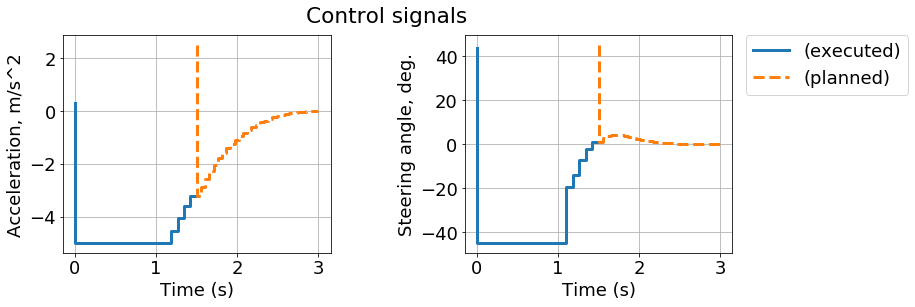

In [7]:
u_plt, u_ax1, u_ax2 = car.plot_u(u_plan, mpcprob.u_opt)
# control limits

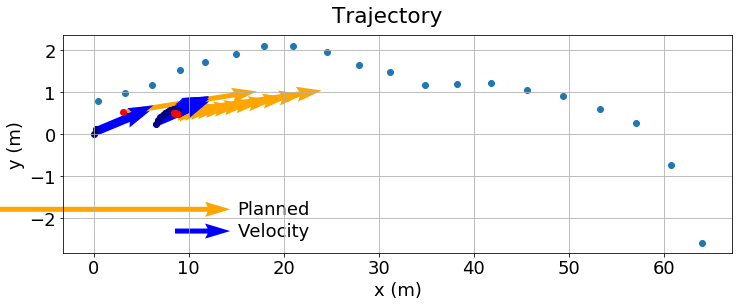

In [8]:
x_plt, x_ax = car.plot_x(x_plan, mpcprob.x_opt)
x_ax.scatter(test_road[0:20,0], test_road[0:20,1])
plt.show()

## x vs time and y vs time, separately, with the boundaries

Final state:
(x,y): 8.410346279946857 0.5159097942508799


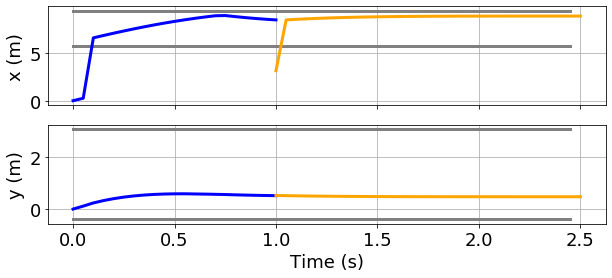

In [9]:
print("Final state:")
print("(x,y):", x_plan[0,-1], x_plan[1,-1])

fig1, ax1, ax2 = mpcprob.model.plot_with_time(x_plan, mpcprob.x_opt, boundary_up, boundary_low)

In [10]:
from roadrunner import Roadrunner
from scipy.optimize import curve_fit
from collections import deque

from road import test_road as road_center

N_POINTS,_ = np.shape(road_center)
road_width = np.ones(N_POINTS)*2.0

angles = np.empty(N_POINTS-1)
for i in range(N_POINTS-1):
    angles[i] = np.arctan2((road_center[i+1,1]-road_center[i,1]),(road_center[i+1,0]-road_center[i,0]))


<Curve (degree=19, dimension=2)>


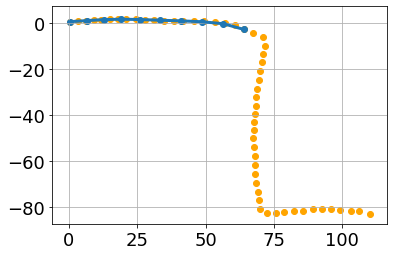

In [11]:
# What to do:
# 1. get better data set - done
# 2. parametrize x(s) and y(s) for road
# 3. better data set should fix data fitting
# 4. better data fitting: curves should match, e.g. curve k ends with derivative k' and curve k+1 should start with derivative k'
# in that way, they are always continuous
# we can set this up (discretely) with ipopt
import bezier
P = 20
nodes = np.asfortranarray(np.transpose(road_center[0:0+P,:]))
curve = bezier.Curve.from_nodes(nodes)
print(curve)
ax = curve.plot(10)
tmp = curve.evaluate_multi(np.linspace(0,1,10))
ax.scatter(road_center[:,0], road_center[:,1], color='orange')
ax.scatter(tmp[0,:], tmp[1,:])


8 -5.381425905574998
9 -2.6785512554432436
10 -4.922860425243141
11 0.33752646084202137
12 0.3395984419639393
13 -2.207756742168605
14 -2.3110619744455505
15 -4.531652156899298
16 -4.93693409911738
17 -15.139624343334068
18 -29.636779759189782
19 -25.33230253619997
20 -25.326064130362724
21 -80.73896765348857
22 -98.67722536691214
23 -99.54409149675736
24 -100.85944305403
25 -95.89370817177544
26 -98.66228569502252
27 -96.455967755681
28 -91.97282626980797
29 -94.21385825745034
30 -94.66617630318545
31 -89.69702866662142
32 -94.66617630318522
33 -85.57446826831827
34 -85.39756324607306
35 -89.7072290197065
36 -89.70931629622368
37 -83.2502269442673
38 -83.2502269442673
39 -85.20468918829303
40 -81.12068155114581
41 -38.08351300955781
42 6.311130216170333
43 6.3285675262452505
44 3.086647393298211
45 6.311130216170084


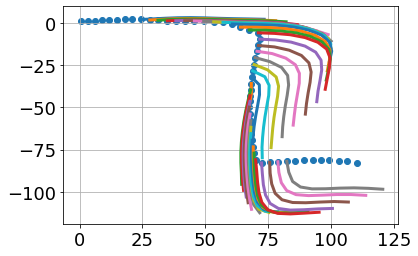

In [12]:
P = 8

for i in range(P, N_POINTS-P):
    road_b = Roadrunner.to_body_frame(road_center[i-P:i+P,:], angles[i])

    nodes = np.asfortranarray(np.transpose(road_b))
    curve = bezier.Curve.from_nodes(nodes)
    
    tmp = curve.evaluate_multi(np.linspace(0,1,10))
    x_b = tmp[0,:]
    y_b = tmp[1,:]
    
    x_b = np.reshape(x_b, (10,1))
    y_b = np.reshape(y_b, (10,1))
    fit_b = np.hstack([x_b, y_b])
    fit_world = Roadrunner.to_world_frame(fit_b, angles[i], offset=road_center[i,:])
    print(i, angles[i]*180/np.pi)
    
    plt.plot(fit_world[:,0], fit_world[:,1], label=str(i))

plt.scatter(road_center[:,0], road_center[:,1])